In [1]:
import cantata
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from box import Box
from cantata.plotting import output as cp


In [2]:
figsize = (14,5)

In [3]:
conf = cantata.config.read('/home/felix/projects/cantata/cantata/configs/1tier.yaml')
batch_size = 1
dt = 1e-3

In [4]:
# Extract populations & projections:
populations = Box()
drivers = Box()
projections = Box()
for pname, pop in conf.input.populations.items():
    p = pop.copy()
    projections[f'input.{pname}'] = p.targets
    del p.targets
    drivers[pname] = p
for aname, area in conf.areas.items():
    for pname, pop in area.populations.items():
        p = pop.copy()
        name = f'{aname}.{pname}'
        projections[name] = p.targets
        del p.targets
        populations[name] = p

In [5]:
second = int(1/dt)

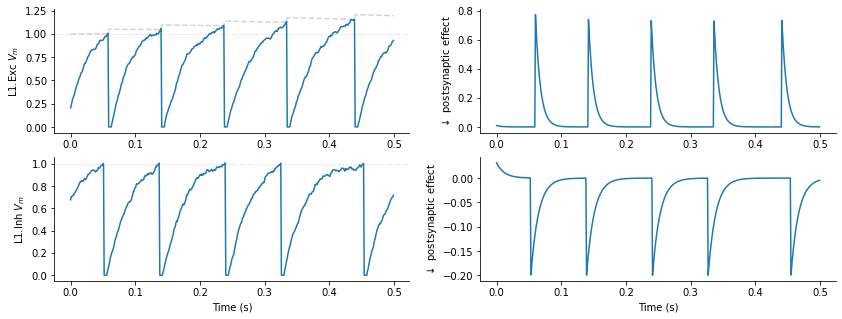

In [9]:
batch_size = 1
n_steps = int(0.5 * second)
t = np.arange(n_steps) * dt

plt.figure(figsize=figsize)
for i, (name, pop) in enumerate(populations.items()):
    cfg = Box(dict(populations = {name:pop.copy()}))
    cfg.populations[name].n = 1
    cfg.populations.__target__ = {'n': 1}
    cfg.populations[name].targets = {'__target__': {}}
    cantata.config.sanitise(cfg, cantata.config.defaults.areas.NAME)
    m = cantata.elements.SNN(cfg, batch_size, dt)
    V = []
    Th = []
    def record_V(membrane, *args):
        V.append(membrane.V[0])
    def record_Th(alif, *args):
        Th.append(alif.threshold[0])
    m.membrane.register_forward_hook(record_V)
    if m.spikes.adaptive:
        m.spikes.register_forward_hook(record_Th)
    with torch.no_grad():
        for _ in t:
            m()
    V = torch.stack(V)
    if m.spikes.adaptive:
        Th = torch.stack(Th)
    
    plt.subplot(2,len(populations),2*i+1)
    plt.axhline(1, c='lightgray', ls='dotted', lw=1)
    if m.spikes.adaptive:
        plt.plot(t, 1+Th[:,0].cpu().numpy(), c='lightgray', ls='--')
    plt.plot(t, V[:,0].cpu().numpy())
    plt.ylabel(f'{name} $V_m$')
    if i==len(populations)-1:
        plt.xlabel('Time (s)')
    
    plt.subplot(2,len(populations),2*i+2)
    plt.plot(t, V[:,1].cpu().numpy())
    plt.ylabel('$\downarrow$ postsynaptic effect')
    if i==len(populations)-1:
        plt.xlabel('Time (s)')
sns.despine()

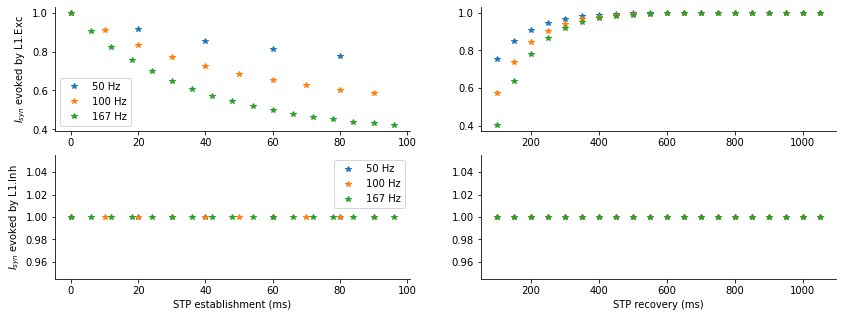

In [20]:
# STP sanity check
establish_end = 100

# To probe establishment - final value is used for recovery:
est_steps = [20,10,6] # Establishment ISIs, ms
X_est = torch.stack([(torch.arange(establish_end)%t==0)*1.0 for t in est_steps], dim=1) # t,est
est_ms = [np.arange(establish_end/s) * s for s in est_steps]
t_est = np.arange(establish_end)

# To probe recovery:
rec_steps = 20 # Number of recovery probes
recover_step = 50 # Spacing between recovery probes, ms
Xd = torch.zeros(establish_end + rec_steps*recover_step, rec_steps, len(est_steps)) # t, rec, est
Xd[:establish_end,:,:] = X_est.unsqueeze(1)
t = establish_end
rec_ms = []
for i in range(rec_steps):
    rec_ms.append(t)
    Xd[t, i, :] = 1.
    t += recover_step

plt.figure(figsize=figsize)
for i, (name, pop) in enumerate(populations.items()):
    pop = pop.copy()
    pop.n = len(est_steps)
    cfg = Box({'populations': {name:pop}})
    cantata.config.sanitise(cfg, cantata.config.defaults.areas.NAME)
    m = cantata.elements.STP(cfg, 1, rec_steps, dt)
    W = []
    with torch.no_grad():
        for X in Xd:
            W.append(m(X)[0] + 1)
    W = torch.stack(W) # t,rec,est
    
    plt.subplot(2,len(populations),2*i+1)
    for j,step in enumerate(est_steps):
        plt.plot(est_ms[j], W[est_ms[j], 0, j].cpu().numpy(), '*',
                 label=f'{1/(dt * step):.0f} Hz')
    plt.legend()
    if i==len(populations)-1:
        plt.xlabel('STP establishment (ms)')
    plt.ylabel(f'$I_{{syn}}$ evoked by {name}')
    
    plt.subplot(2,len(populations),2*i+2)
    for j,step in enumerate(est_steps):
        plt.plot(
            rec_ms,
            W[rec_ms, range(rec_steps), j].cpu().numpy(), '*')
    if i==len(populations)-1:
        plt.xlabel('STP recovery (ms)')
sns.despine()

In [11]:
# STDP check: Engineered pairs
def stdp_plot(source_name, target_name,
              n_probes = 51, probe_spacing = 0.002,
              burst = 1, burst_spacing = 0.005,
              v_post = 0.5, with_noise = False, batch_size = 32,
              plot_traces = True,
              kd = 1, kp = 1,
              w = 0):
    stdp_cfg = base_cfg.copy()
    stdp_cfg.batch_size = batch_size
    stdp_cfg.n_inputs = 1
    stdp_cfg.n_steps = int(n_probes * probe_spacing / stdp_cfg.time_step) + 10
    stdp_cfg.model.populations.Driver_vpost = Box(dict(rate=0, targets={'Post':{}}))
    stdp_cfg.model.wmax = 2
    stdp_cfg.model.tau_ref = 0
    stdp_cfg.model.tau_mem_gamma = 0
    
    if with_noise:
        inputs = torch.zeros(stdp_cfg.batch_size, stdp_cfg.n_steps, stdp_cfg.n_inputs, **stdp_cfg.tspec)
    else:
        inputs = torch.ones(stdp_cfg.batch_size, stdp_cfg.n_steps, stdp_cfg.n_inputs, **stdp_cfg.tspec)\
            /stdp_cfg.time_step
    
    burst_idx = torch.ones(burst)*(1 + int(n_probes//2 * probe_spacing/stdp_cfg.time_step)) + \
        torch.arange(0,-burst,-1) * burst_spacing/stdp_cfg.time_step

    t = np.arange(stdp_cfg.n_steps) * .001/stdp_cfg.time_step
    dt = (np.arange(n_probes) - n_probes//2) * probe_spacing * 1000

    proj = projections[source_name][target_name]
    source = (populations[source_name] if source_name in populations else drivers[source_name]).copy()
    source.n = n_probes
    source.th_ampl = 0
    if not with_noise:
        source.noise_N = 0
    source.targets = {'Post': dict(
        A_p = proj.A_p*kp,
        A_d = proj.A_d*kd,
        STDP_frac = 0 # Compute STDP, but manipulate postsynaptic membrane effects independently
    )}
    stdp_cfg.model.populations.Pre = source
    
    target = populations[target_name].copy()
    target.n = n_probes
    if not with_noise:
        target.noise_N = 0
    stdp_cfg.model.populations.Post = target

    cantata.config.load(stdp_cfg)
    m = cantata.Module()
    iPre, iPost = m.p_idx[m.p_names.index('Pre')], m.p_idx[m.p_names.index('Post')]
    with torch.no_grad():
        state,epoch,record = m.forward_init(inputs, ['w_stdp', 'mem'])
        state.mem[:] = 0
        state.mem[:,iPost] = v_post
        if m.Clopath:
            state.u_dep[:,iPost] = v_post
            state.u_pot[:,iPost] = v_post
        m.w[m.p_idx[m.p_names.index('Driver_vpost')], iPost] = v_post - v_post*m.alpha_mem
        m.w[iPre] = 0
        m.w[iPre, iPost] = w
        state.w_stdp[:, iPre] = 0
        state.w_stdp[:, iPre, iPost] = 1
        
        for i in range(n_probes):
            epoch.input[:, int(probe_spacing*i/stdp_cfg.time_step), iPre[i]] = 1
        epoch.input[:, burst_idx.to(torch.long), iPost] = 1-v_post
        
        m.forward_run(state,epoch,record)
        m.forward_close(record)

    if plot_traces:
        plt.figure(figsize=figsize)
        for i,k in enumerate(range(n_probes)):
            plt.subplot(n_probes,2,2*i+1)
            plt.plot(record.mem[0,:,iPre[k]].cpu().numpy(), label='pre')
            plt.plot(record.mem[0,:,iPost[k]].cpu().numpy(), label='post')
            if i < n_probes-1:
                plt.axis('off')
            else:
                sns.despine()
                plt.xlabel('Time (ms)')

            ax = plt.subplot(n_probes,2,2*i+2)
            plt.plot(record.w_stdp[0,:, iPre[k], iPost[k]].cpu().numpy())
            if i < n_probes-1:
                plt.axis('off')
            else:
                ax.get_yaxis().set_visible(False)
                sns.despine(left=True)
                plt.xlabel('Time (ms)')

    plt.figure(figsize=figsize)
    plt.axhline(0, c='lightgray', ls='--')
    first_half = np.ones(n_probes//2 + 1) * (2 + int(n_probes//2 * probe_spacing/stdp_cfg.time_step))# + 1
    second_half = np.arange(1, n_probes//2+1) * probe_spacing/stdp_cfg.time_step + first_half[0]-1
    idx_after = torch.tensor(np.concatenate((first_half, second_half)),dtype=torch.long)
    dw = record.w_stdp[:, idx_after, iPre, iPost] - \
         record.w_stdp[:, idx_after-1, iPre, iPost]
    dw_0 = np.flip(dw[0].cpu().numpy())
    plt.plot(dt, dw_0, 'g*-')
    plt.xlabel('t_post - t_pre (ms)')
    plt.ylabel('Relative weight change')
    
    if with_noise:
        dw_mean = np.flip(dw.mean(dim=0).cpu().numpy())
        plt.plot(dt, dw_mean, 'ro-')
        return dw_0, dw_mean
    else:
        return dw_0

In [12]:
def stdp_check_all(**kwargs):
    for source_name, targets in projections.items():
        for target_name, projection in targets.items():
            if projection.STDP_frac > 0:
                stdp_plot(source_name, target_name, **kwargs)

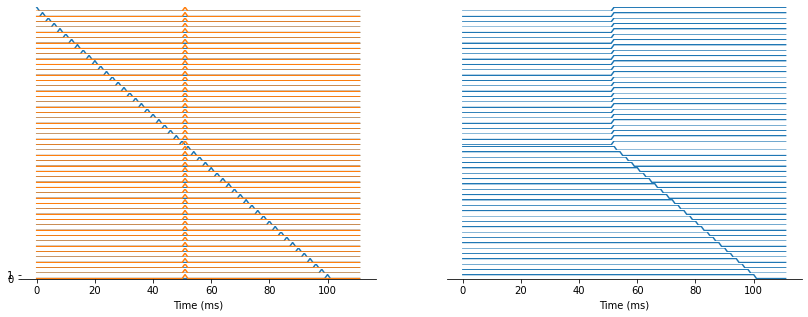

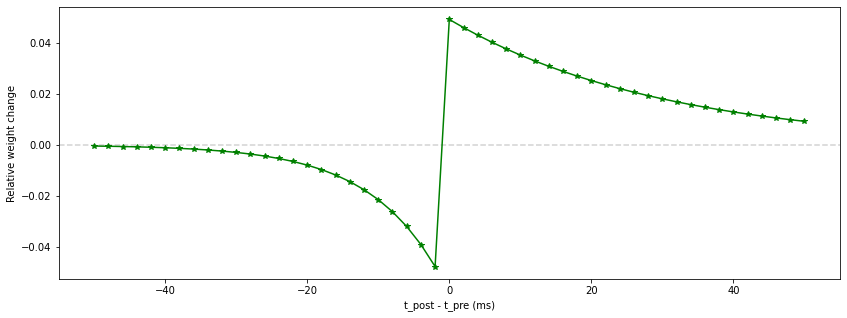

In [13]:
stdp_check_all(v_post=0.0)

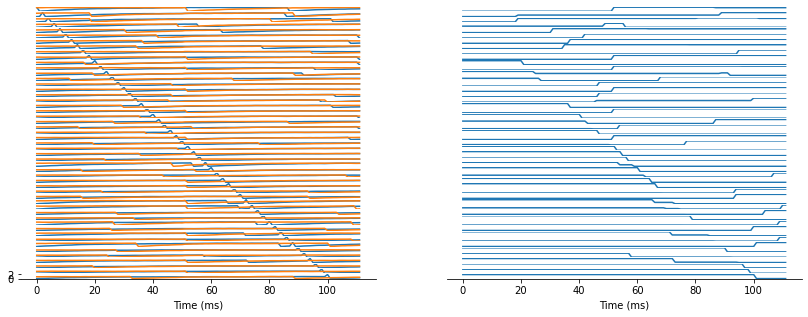

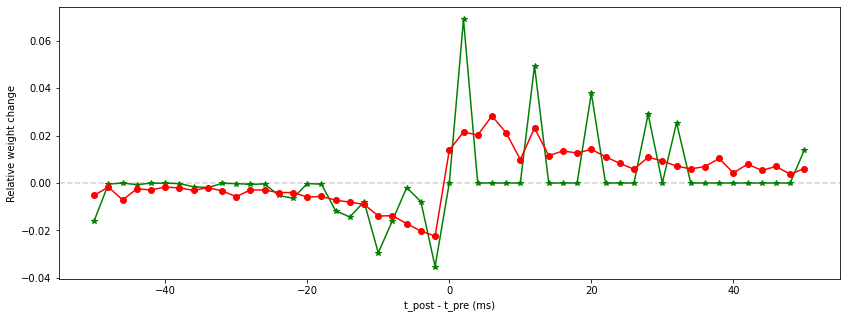

In [14]:
stdp_check_all(v_post = 0.9, with_noise = True, kp = 1.5)